# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [1]:
#from google.colab import drive

#drive.mount('/gdrive')
#%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 1

## ⚙️ Import Libraries

In [2]:
# Fix library versions (for colab).
#!python3 -m pip uninstall tensorflow -y
#!python3 -m pip uninstall keras -y
#!python3 -m pip uninstall keras-cv -y
#!python3 -m pip install keras-cv
#!python3 -m pip install tensorflow==2.17.0
#!python3 -m pip install keras==3.4.1

In [3]:
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

import keras_cv.layers

seed = 11037
np.random.seed(seed)
tf.random.set_seed(seed)

import random
random.seed(seed)

2024-11-14 18:37:26.217618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 18:37:26.241133: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 18:37:26.249634: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 18:37:26.267640: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-14 18:37:27.738781: W tensorflow/compiler/tf2

## ⏳ Load the Data

In [4]:
# Read training_set.npz to get the dataframe.
data = np.load('training_set.npz', allow_pickle=True)

# Normal images up to 11958, shrek from 11959 to 13558, rick from 13559 to 13758.
images = data['images'][:11959]
labels = data['labels'][:11959]

In [5]:
# Images are stored as 96x96x3 numpy arrays.
print("Shape of all images:")
print(images[0].shape)

# Count the images.
print()
print("Total number of images: ")
total_num_images = images.shape[0]
print(total_num_images)

# Count the amount of images with a given label.
print()
print("Number of images with a given label:")
for n, elm in enumerate(np.unique(labels, return_counts=True)[-1]):
    print(f"Label {n}: {elm} ({np.round(elm/total_num_images*100, 1)}%)")

Shape of all images:
(96, 96, 3)

Total number of images: 
11959

Number of images with a given label:
Label 0: 852 (7.1%)
Label 1: 2181 (18.2%)
Label 2: 1085 (9.1%)
Label 3: 2026 (16.9%)
Label 4: 849 (7.1%)
Label 5: 993 (8.3%)
Label 6: 2330 (19.5%)
Label 7: 1643 (13.7%)


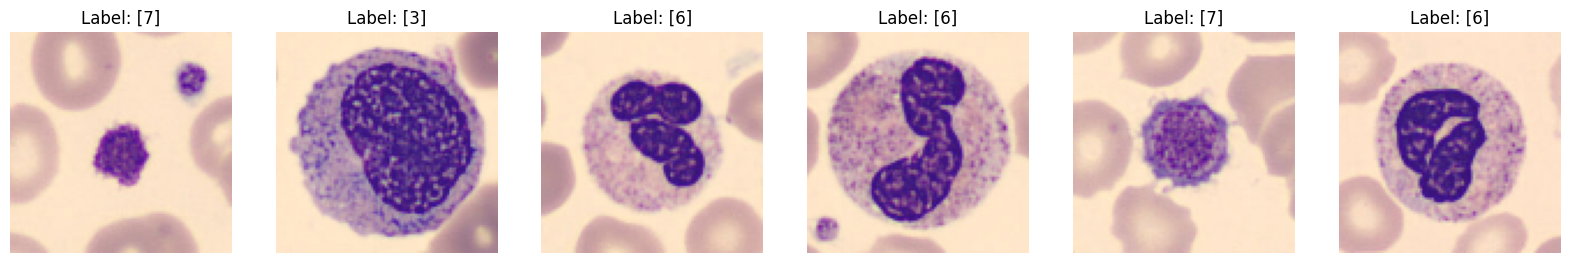

In [6]:
# Display the first few images with matplotlib.
plotted_images = 6
fig, axs = plt.subplots(1, plotted_images, figsize=(20, 20))

for i in range(plotted_images):
    axs[i].imshow(images[i])
    axs[i].set_title(f"Label: {labels[i]}")
    axs[i].axis('off')

plt.show()


## Split in train, validation and test sets

In [7]:
from sklearn.model_selection import train_test_split

# Split the dataset into a combined training and validation set, and a separate
# test set.
"""
X_train_val, X_test, y_train_val, y_test = train_test_split(
    images,
    labels,
    test_size=0.1,
    random_state=seed,
    stratify=labels
)
"""
X_train_val = images
y_train_val = labels

# Split the training and validation sets.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.2,
    random_state=seed,
    stratify=y_train_val
)

# Print the shapes of the resulting sets.
print('Overall shape:\t\t', images.shape, labels.shape)
print('Training set shape:\t', X_train.shape, y_train.shape)
print('Validation set shape:\t', X_val.shape, y_val.shape)
#print('Test set shape:\t\t', X_test.shape, y_test.shape)

Overall shape:		 (11959, 96, 96, 3) (11959, 1)
Training set shape:	 (9567, 96, 96, 3) (9567, 1)
Validation set shape:	 (2392, 96, 96, 3) (2392, 1)


## Process data

### Normalize data and encode labels

In [8]:
# Normalize data to the range [0, 1].
X_train = (X_train / 255).astype('float32')
X_val = (X_val / 255).astype('float32')

# Print the first few pixel values of the first image, to verify that the
# normalization was successful.
print('First image pixel values:')
print(X_train[0, 0, 0, :])

y_train = tfk.utils.to_categorical(y_train)
y_val = tfk.utils.to_categorical(y_val)

First image pixel values:
[0.8156863  0.67058825 0.6666667 ]


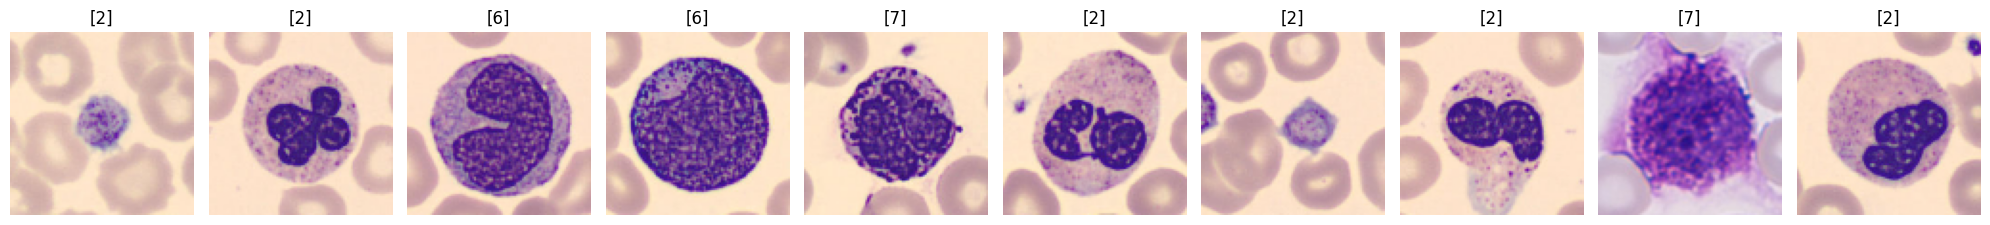

In [9]:
# Display a sample of images from the dataset.
set_to_sample = X_train
labels_to_sample = y_train
num_img = 10
random_indices = random.sample(range(len(set_to_sample)), num_img)

fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images.
for i, idx in enumerate(random_indices):
    ax = axes[i % num_img]
    ax.imshow(np.squeeze(set_to_sample[idx]), vmin=0., vmax=1.)
    ax.set_title(str(data['labels'][np.argmax(labels_to_sample[idx])]))
    ax.axis('off')

# Adjust layout and display the images.
plt.tight_layout()
plt.show()

## 💪 Image Augmentation

I0000 00:00:1731605858.853886  120955 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731605858.918353  120955 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731605858.919968  120955 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731605858.923302  120955 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

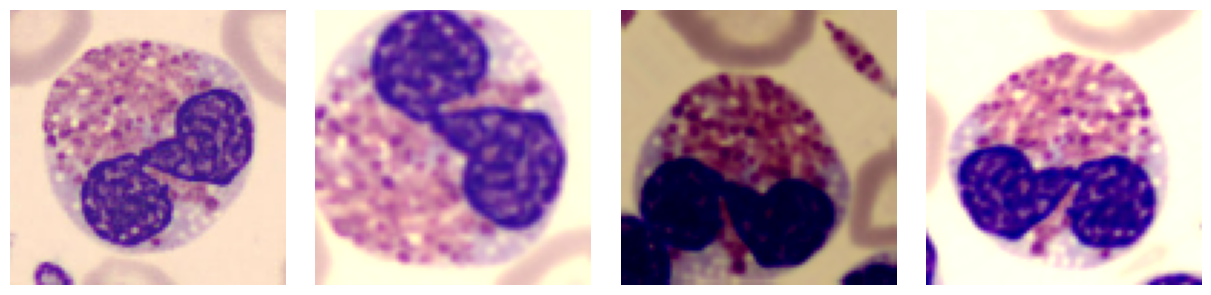

In [10]:
import matplotlib.gridspec as gridspec
img = X_train[0]

# Define a sequential model for image augmentation.
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    tfkl.RandomContrast(0.75),
], name='preprocessing')

# Set up the figure and grid layout for displaying images.
fig = plt.figure(constrained_layout=True, figsize=(12, 3))
gs = gridspec.GridSpec(1, 4, figure=fig, width_ratios=[1, 1, 1, 1], wspace=0.1)

# Display the original image.
ax1 = fig.add_subplot(gs[0])
ax1.imshow(np.squeeze(img))
ax1.axis('off')

# Apply augmentation and display the first augmented image.
augmented_img = np.clip(augmentation(img)._numpy().astype('float32'), 0., 1.)
ax2 = fig.add_subplot(gs[1])
ax2.imshow(np.squeeze(augmented_img))
ax2.axis('off')

# Apply augmentation again and display the second augmented image.
augmented_img = np.clip(augmentation(img)._numpy().astype('float32'), 0., 1.)
ax3 = fig.add_subplot(gs[2])
ax3.imshow(np.squeeze(augmented_img))
ax3.axis('off')

# Apply augmentation again and display the third augmented image.
augmented_img = np.clip(augmentation(img)._numpy().astype('float32'), 0., 1.)
ax4 = fig.add_subplot(gs[3])
ax4.imshow(np.squeeze(augmented_img))
ax4.axis('off')

# Show the figure with all images.
plt.show()

In [11]:
# Create a preprocessing pipeline with augmentations.
batch_size = 128
num_classes = 8
augmenter = keras_cv.layers.Augmenter(
    [
        keras_cv.layers.RandomFlip(seed=seed),
        keras_cv.layers.RandAugment(value_range=(0, 1),seed=seed),
        keras_cv.layers.CutMix(seed=seed),
        #keras_cv.layers.AugMix(value_range=(0, 1),seed=seed),
    ],
)

def preprocess_data(images, labels, augment=False):
    # Convert labels to categorical format using one-hot encoding.
    inputs = {"images": images, "labels": labels}
    outputs = inputs
    if augment:
        outputs = augmenter(outputs)
    return outputs['images'], outputs['labels']

# Augment the training and validation datasets.
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

train_dataset = train_dataset.batch(batch_size).map(
    lambda x, y: preprocess_data(x, y, augment=True),
        num_parallel_calls=tf.data.AUTOTUNE).prefetch(
            tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

val_dataset = val_dataset.batch(batch_size).map(
    lambda x, y: preprocess_data(x, y, augment=True),
        num_parallel_calls=tf.data.AUTOTUNE).prefetch(
            tf.data.AUTOTUNE)

2024-11-14 18:37:42.603608: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1058033664 exceeds 10% of free system memory.
2024-11-14 18:37:43.902447: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1058033664 exceeds 10% of free system memory.


## 🧮 Define Network Parameters

In [12]:
# Input shape for the model.
input_shape = train_dataset.element_spec[0].shape[1:]

# Output shape for the model.
output_shape = train_dataset.element_spec[1].shape[1]

print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [13]:
# Number of training epochs.
epochs = 1000

# Batch size for training.
batch_size = 128

# Learning rate: step size for updating the model's weights.
learning_rate = 0.001

# Print the defined parameters.
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Learning Rate:", learning_rate)

Epochs: 1000
Batch Size: 128
Learning Rate: 0.001


## 🛠️ Build the Model

In [14]:
# Define the Residual block with configurable parameters
def residual_block(x, filters, kernel_size=3, padding='same',
                   downsample=True, activation='relu', stack=2, name='residual'):

    for s in range(stack):
        # Save input for skip connection
        skip = x

        # First convolutional block with Batch Normalisation and activation
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv1_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(x)
        x = tfkl.Activation(activation, name=f'{name}_act1_{s}')(x)

        # Second convolutional block
        x = tfkl.Conv2D(filters, kernel_size, padding=padding, name=f'{name}_conv2_{s}')(x)
        x = tfkl.BatchNormalization(name=f'{name}_bn2_{s}')(x)

        # Adjust skip connection dimension if needed
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    # Optional downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [15]:
# Define the Inception block with BN and with multiple convolution paths and optional downsampling
def inception_block_bn(x, filters, padding='same',
                       downsample=True, activation='relu', stack=2, name='inception'):
    # Loop through specified stack layers for multiple inception paths
    for s in range(stack):
        # 1x1 convolution path with batch normalization and activation
        conv1 = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_conv1_{s}')(x)
        conv1 = tfkl.BatchNormalization(name=f'{name}_bn1_{s}')(conv1)
        conv1 = tfkl.Activation(activation, name=f'{name}_act1_{s}')(conv1)

        # 3x3 convolution path with initial reduction layer
        conv3_reduce = tfkl.Conv2D(filters // 8, 1, padding=padding, name=f'{name}_conv3_reduce_{s}')(x)
        conv3_reduce = tfkl.BatchNormalization(name=f'{name}_bn3_reduce_{s}')(conv3_reduce)
        conv3_reduce = tfkl.Activation(activation, name=f'{name}_act3_reduce_{s}')(conv3_reduce)
        conv3 = tfkl.Conv2D(filters // 4, 3, padding=padding, name=f'{name}_conv3_{s}')(conv3_reduce)
        conv3 = tfkl.BatchNormalization(name=f'{name}_bn3_{s}')(conv3)
        conv3 = tfkl.Activation(activation, name=f'{name}_act3_{s}')(conv3)

        # 5x5 convolution path with initial reduction layer
        conv5_reduce = tfkl.Conv2D(filters // 12, 1, padding=padding, name=f'{name}_conv5_reduce_{s}')(x)
        conv5_reduce = tfkl.BatchNormalization(name=f'{name}_bn5_reduce_{s}')(conv5_reduce)
        conv5_reduce = tfkl.Activation(activation, name=f'{name}_act5_reduce_{s}')(conv5_reduce)
        conv5 = tfkl.Conv2D(filters // 4, 5, padding=padding, name=f'{name}_conv5_{s}')(conv5_reduce)
        conv5 = tfkl.BatchNormalization(name=f'{name}_bn5_{s}')(conv5)
        conv5 = tfkl.Activation(activation, name=f'{name}_act5_{s}')(conv5)

        # Pooling path with projection for spatial dimensionality reduction
        pool = tfkl.MaxPooling2D(3, strides=1, padding=padding, name=f'{name}_pooling_{s}')(x)
        pool_proj = tfkl.Conv2D(filters // 4, 1, padding=padding, name=f'{name}_pool_proj_{s}')(pool)
        pool_proj = tfkl.BatchNormalization(name=f'{name}_bn_pool_proj_{s}')(pool_proj)
        pool_proj = tfkl.Activation(activation, name=f'{name}_act_pool_proj_{s}')(pool_proj)

        # Concatenate all paths to form the final block output
        x = tfkl.Concatenate(name=f'{name}_concat_{s}')([conv1, conv3, conv5, pool_proj])

    # Apply downsampling if specified
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)
    return x

In [16]:
# Define the a residual block using an inception block instead of the 
# convolutional path.
def inception_residual(x, filters, padding='same', downsample=True, 
                       activation='relu', stack=2, inception_stack=2,
                       name='residual'):

    for s in range(stack):
        # Save input for skip connection.
        skip = x

        # Create the inception block.
        x = inception_block_bn(x, filters, padding, downsample=False, activation=activation,
                               stack=inception_stack, name=f'{name}_inception_{s}')

        # Adjust skip connection dimension if needed.
        if skip.shape[-1] != filters:
            skip = tfkl.Conv2D(filters, 1, padding=padding, name=f'{name}_proj_{s}')(skip)
            skip = tfkl.BatchNormalization(name=f'{name}_proj_bn_{s}')(skip)

        # Add skip connection and apply activation.
        x = tfkl.Add(name=f'{name}_add_{s}')([x, skip])
        x = tfkl.Activation(activation, name=f'{name}_act2_{s}')(x)

    # Optional downsampling
    if downsample:
        x = tfkl.MaxPooling2D(2, name=f'{name}_pool')(x)

    return x

In [17]:
def build_model(
    input_shape=input_shape,
    output_shape=output_shape,
    learning_rate=learning_rate,
    augmentation=None,
    seed=seed
):
    # Set the random seed for reproducibility.
    tf.random.set_seed(seed)

    # Define the input layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Apply optional data augmentation.
    if augmentation == None:
        x = input_layer
    else:
        x = augmentation(input_layer)

    # Apply first convolutional layer, activation, and pooling.
    x = tfkl.Conv2D(filters=32, kernel_size=3, padding='same', name='conv0')(x)
    x = tfkl.ReLU(name='relu0')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    # Apply second convolutional layer, activation, and pooling.
    x = tfkl.Conv2D(filters=64, kernel_size=3, padding='same', name='conv1')(x)
    x = tfkl.ReLU(name='relu1')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    # Add two residual blocks.
    x = inception_residual(x, filters=144, downsample=True, stack=2, inception_stack=2, name='res1')

    # Add two more residual blocks.
    x = inception_residual(x, filters=288, downsample=True, stack=2, inception_stack=2, name='res2')

    # Apply global average pooling.
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)

    # Add a dense layer with activation.
    x = tfkl.Dense(units=128, name='dense1')(x)
    x = tfkl.ReLU(name='relu5')(x)
    # Add a dropout layer to prevent overfitting.
    x = tfkl.Dropout(rate=0.6, name='dropout')(x)

    # Define the output layer with softmax activation for classification.
    x = tfkl.Dense(units=output_shape, name='dense2')(x)
    output_layer = tfkl.Activation('softmax', name='softmax')(x)

    # Create the model.
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='CNN')

    # Compile the model with categorical crossentropy loss and Adam optimizer.
    loss = tfk.losses.CategoricalCrossentropy()
    optimizer = tfk.optimizers.Adam(learning_rate)
    metrics = ['accuracy']
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    # Return the compiled model.
    return model

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ Input             │ (None, 96, 96,  │         0 │ -              │   -   │
│ (InputLayer)      │ 3)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv0 (Conv2D)    │ (None, 96, 96,  │       896 │ Input[0][0]    │   Y   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ relu0 (ReLU)      │ (None, 96, 96,  │         0 │ conv0[0][0]    │   -   │
│                   │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ mp0               │ (None, 48, 48,  │         0 │ relu0[0][0]    │   -   │
│ (MaxPooling2D)    │ 32)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1 (Conv2D)    │ (None, 48, 48,  │    18,496 │ mp0[0][0]      │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ relu1 (ReLU)      │ (None, 48, 48,  │         0 │ conv1[0][0]    │   -   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ mp1               │ (None, 24, 24,  │         0 │ relu1[0][0]    │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │     1,170 │ mp1[0][0]      │   Y   │
│ (Conv2D)          │ 18)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │       780 │ mp1[0][0]      │   Y   │
│ (Conv2D)          │ 12)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │        72 │ res1_inceptio… │   Y   │
│ (BatchNormalizat… │ 18)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │        48 │ res1_inceptio… │   Y   │
│ (BatchNormalizat… │ 12)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │         0 │ res1_inceptio… │   -   │
│ (Activation)      │ 18)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │         0 │ res1_inceptio… │   -   │
│ (Activation)      │ 12)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │         0 │ mp1[0][0]      │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │     2,340 │ mp1[0][0]      │   Y   │
│ (Conv2D)          │ 36)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │     5,868 │ res1_inceptio… │   Y   │
│ (Conv2D)          │ 36)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ res1_inception_0… │ (None, 24, 24,  │    10,836 │ res1_inceptio… │   Y 

 Total params: 709,568 (2.71 MB)

 Trainable params: 704,528 (2.69 MB)

 Non-trainable params: 5,040 (19.69 KB)

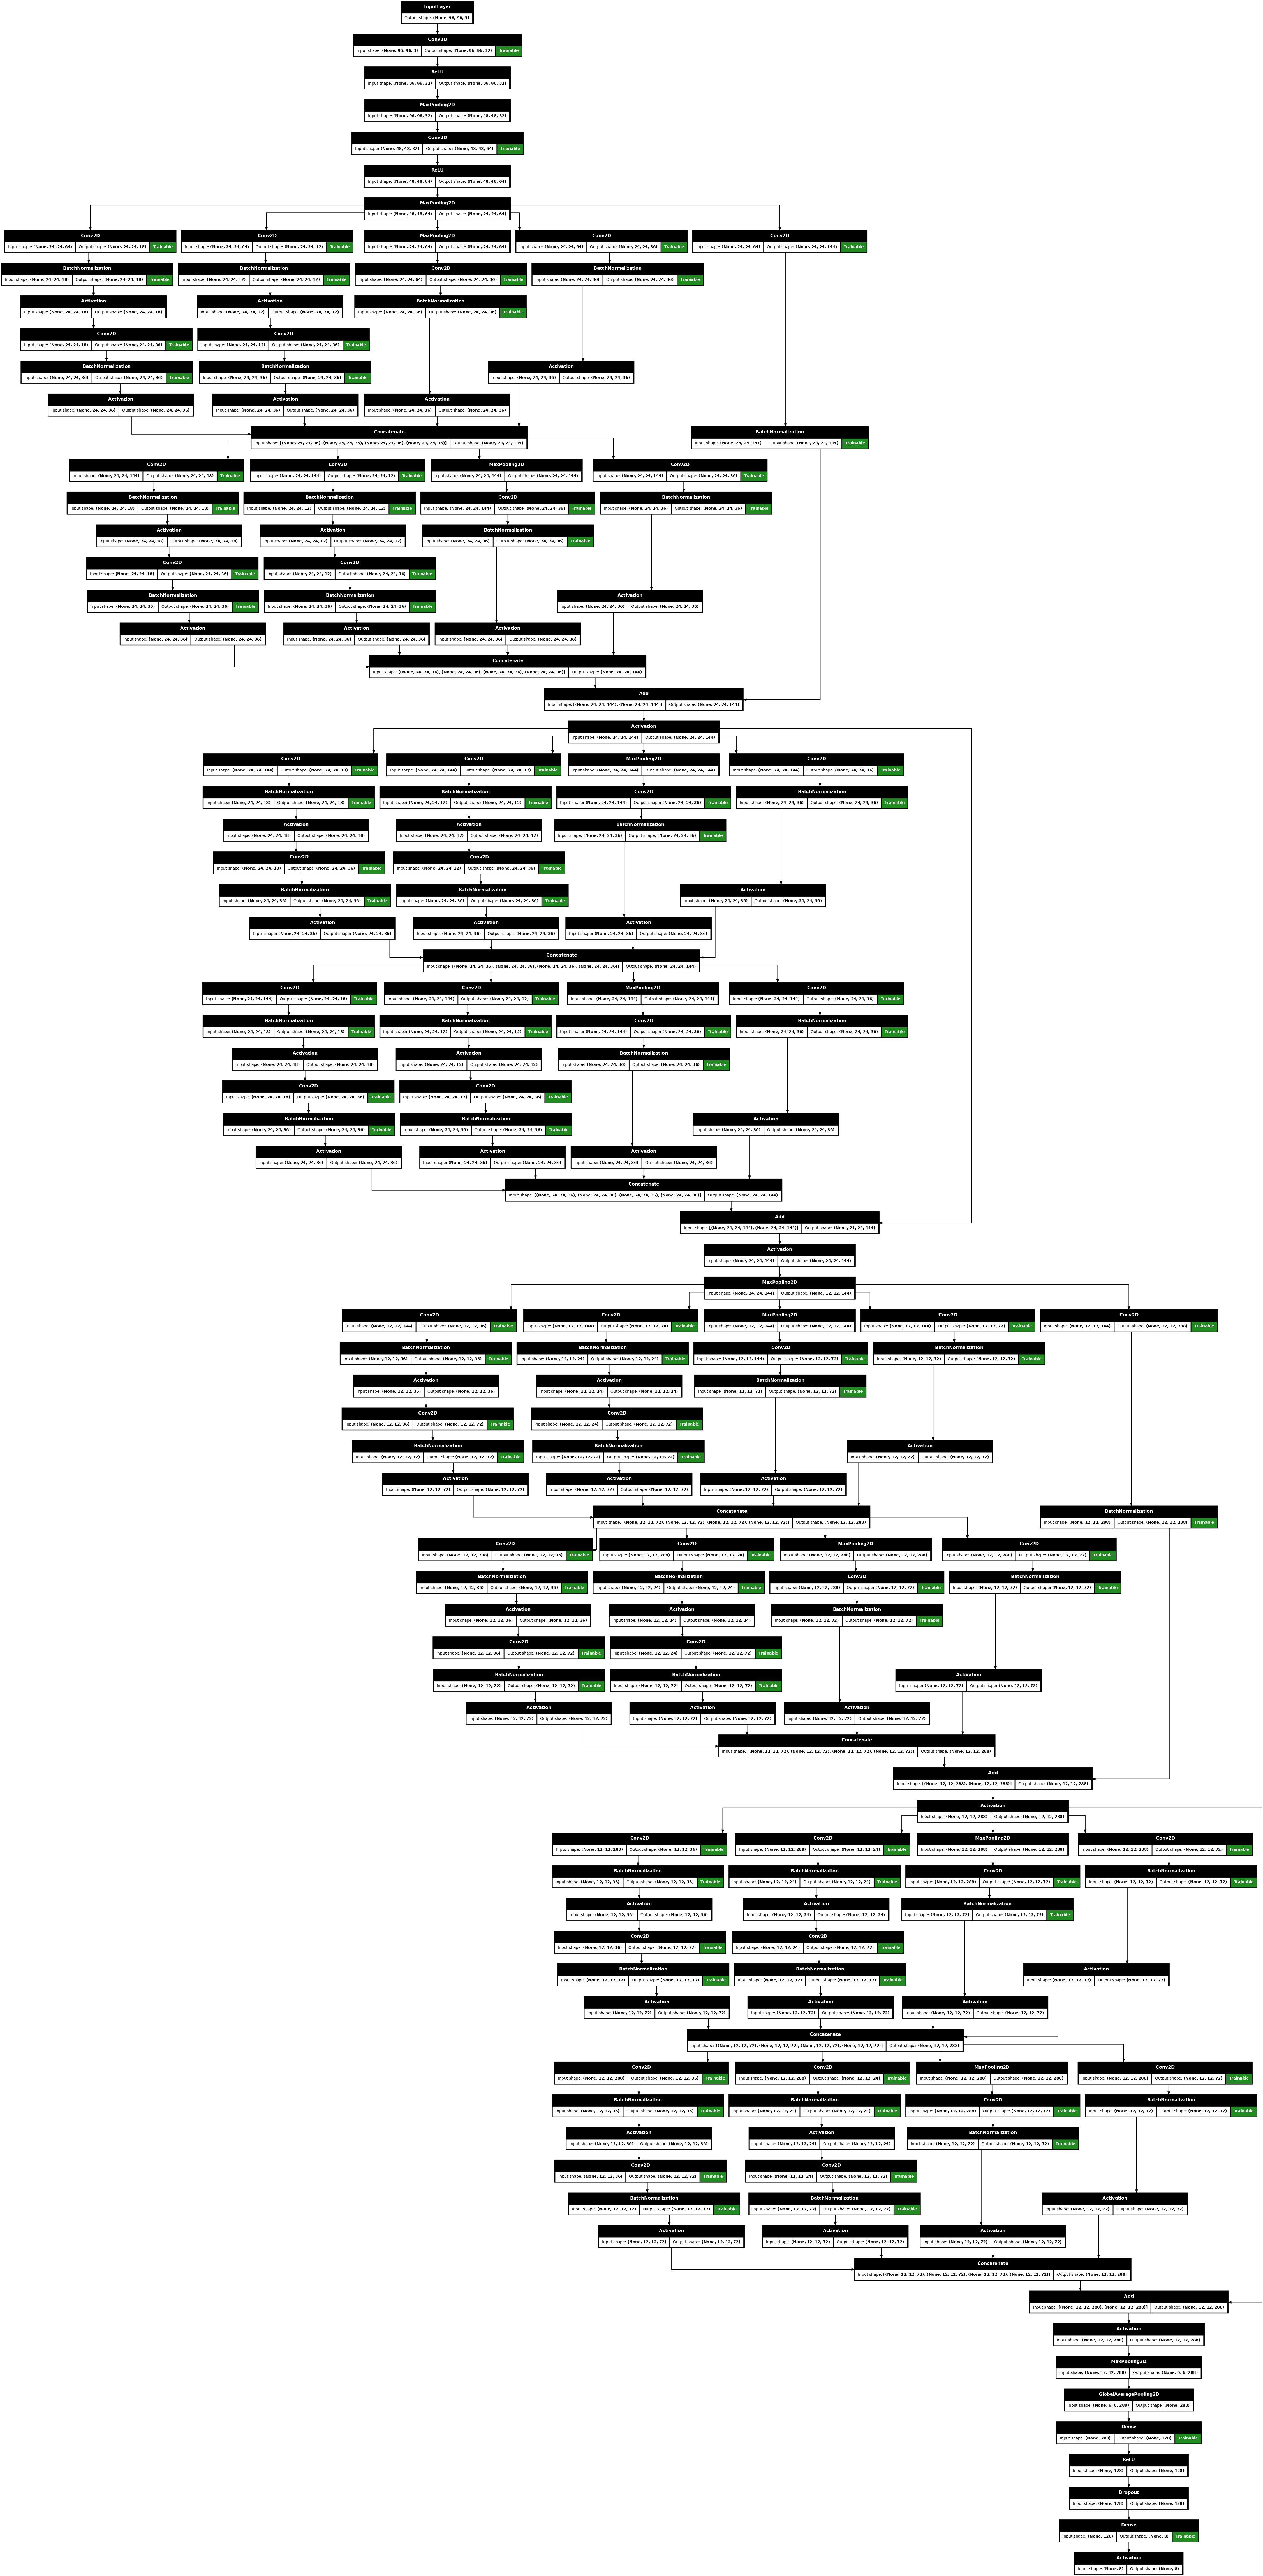

In [18]:
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.2,0.2),
    tfkl.RandomRotation(0.2),
    tfkl.RandomZoom(0.2),
    tfkl.RandomBrightness(0.5, value_range=(0,1)),
    tfkl.RandomContrast(0.75),
], name='preprocessing')

# Build the model with specified input and output shapes.
model = build_model(augmentation=None)

# Display a summary of the model architecture.
model.summary(expand_nested=True, show_trainable=True)

# Plot the model architecture.
tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## 🛠️ Train and Save the Model

In [19]:
# Define the patience value for early stopping.
patience = 40

# Create an EarlyStopping callback.
early_stopping = tfk.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=patience,
    restore_best_weights=True
)

reduce_lr = tfk.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=patience//2
)

checkpoint = tfk.callbacks.ModelCheckpoint(
    '{epoch:02d}-{val_loss:.2f}.keras', 
    save_freq="epoch"
) 

# Store the callback in a list.
callbacks = [early_stopping, reduce_lr, checkpoint]

In [20]:
# Train the model with early stopping callback.
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_dataset,
    callbacks=callbacks
).history

# Calculate and print the final validation accuracy.
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename.
model_filename = 'weights.keras'
model.save(model_filename)

# Delete the model to free up resources.
del model

Epoch 1/1000


2024-11-14 18:37:56.000873: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1058033664 exceeds 10% of free system memory.
I0000 00:00:1731605923.462352  121293 service.cc:146] XLA service 0x643beb97e7f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731605923.462422  121293 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-11-14 18:38:45.145446: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-14 18:38:50.098334: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1731605960.774625  121293 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


75/75 ━━━━━━━━━━━━━━━━━━━━ 166s 1s/step - accuracy: 0.1744 - loss: 2.5954 - val_accuracy: 0.1338 - val_loss: 2.0900 - learning_rate: 0.0010
Epoch 2/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 39s 472ms/step - accuracy: 0.2469 - loss: 1.9658 - val_accuracy: 0.2086 - val_loss: 2.0068 - learning_rate: 0.0010
Epoch 3/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 494ms/step - accuracy: 0.2845 - loss: 1.9172 - val_accuracy: 0.2178 - val_loss: 2.0634 - learning_rate: 0.0010
Epoch 4/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 490ms/step - accuracy: 0.3256 - loss: 1.8582 - val_accuracy: 0.1823 - val_loss: 2.3319 - learning_rate: 0.0010
Epoch 5/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 41s 494ms/step - accuracy: 0.3506 - loss: 1.8317 - val_accuracy: 0.1793 - val_loss: 2.7289 - learning_rate: 0.0010
Epoch 6/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 42s 502ms/step - accuracy: 0.3730 - loss: 1.7881 - val_accuracy: 0.1806 - val_loss: 2.3794 - learning_rate: 0.0010
Epoch 7/1000
75/75 ━━━━━━━━━━━━━━━━━━━━ 43s 514ms/step - accuracy: 0.3948 - loss: 1.7

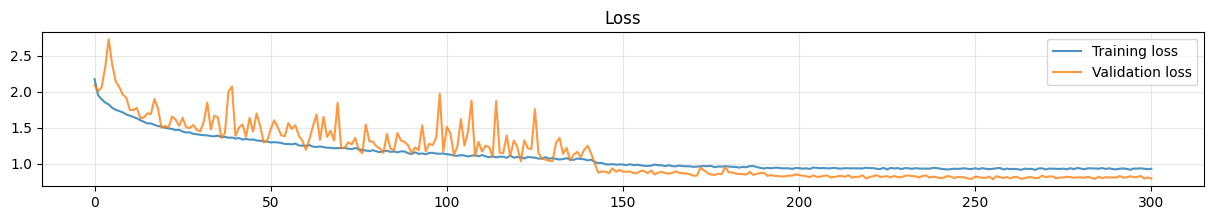

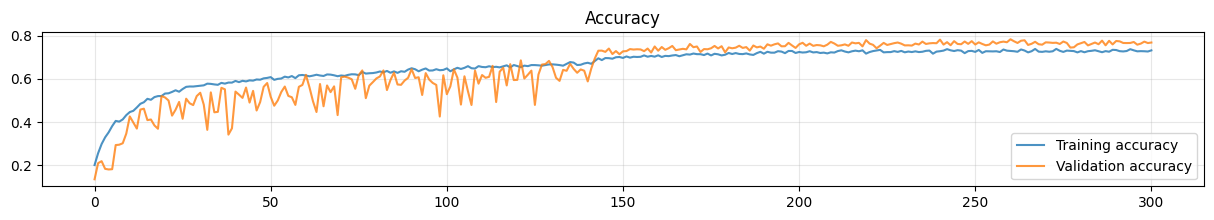

In [21]:
# Plot training and validation loss.
plt.figure(figsize=(15, 2))
plt.plot(history['loss'], label='Training loss', alpha=.8)
plt.plot(history['val_loss'], label='Validation loss', alpha=.8)
plt.title('Loss')
plt.legend()
plt.grid(alpha=.3)

# Plot training and validation accuracy.
plt.figure(figsize=(15, 2))
plt.plot(history['accuracy'], label='Training accuracy', alpha=.8)
plt.plot(history['val_accuracy'], label='Validation accuracy', alpha=.8)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## 📊 Prepare the Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [34]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        # Load the CNN.
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        # Map X to [0,1].
        X_normalized = (X / 255).astype('float32')

        # Predict.
        preds = self.neural_network.predict(X_normalized)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [33]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed.
!zip {filename} model.py weights.keras

#from google.colab import files
#files.download(filename)

  adding: model.py (deflated 39%)
  adding: weights.keras (deflated 16%)


## 🕹️ Test the Model

In [35]:
import importlib
import model
importlib.reload(model)
model_object = model.Model()

75/75 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step
Accuracy score over the test set: 0.9883
Precision score over the test set: 0.9884
Recall score over the test set: 0.9883
F1 score over the test set: 0.9883


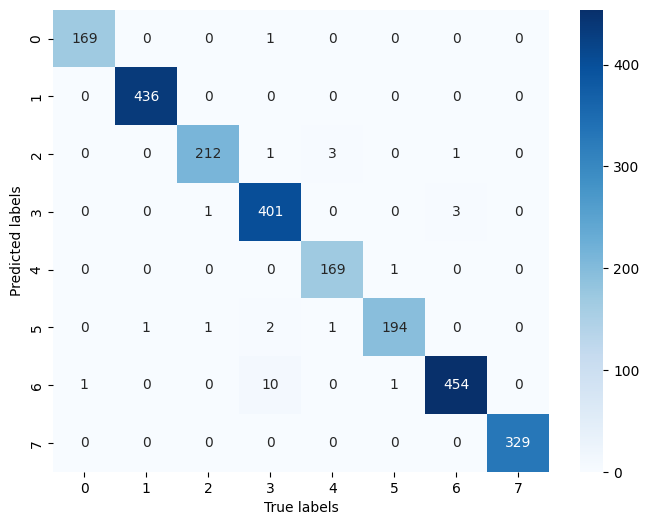

In [36]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

# Predict class probabilities and get predicted classes.
test_predictions = model_object.predict(X_val * 255)

# Extract ground truth classes.
test_gt = np.argmax(y_val, axis=1)

# Calculate and display test set accuracy.
test_accuracy = accuracy_score(test_gt, test_predictions)
print(f'Accuracy score over the test set: {round(test_accuracy, 4)}')

# Calculate and display test set precision.
test_precision = precision_score(test_gt, test_predictions, average='weighted')
print(f'Precision score over the test set: {round(test_precision, 4)}')

# Calculate and display test set recall.
test_recall = recall_score(test_gt, test_predictions, average='weighted')
print(f'Recall score over the test set: {round(test_recall, 4)}')

# Calculate and display test set F1 score.
test_f1 = f1_score(test_gt, test_predictions, average='weighted')
print(f'F1 score over the test set: {round(test_f1, 4)}')

# Compute the confusion matrix.
cm = confusion_matrix(test_gt, test_predictions)

# Create labels combining confusion matrix values.
labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix with class labels.
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', xticklabels=range(8), yticklabels=range(8), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()